In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

In [6]:
# reading the dataset 

df = pd.read_csv('Algerian_forest_fires_dataset_UPDATE_CLEAN.csv')
df.head()


print("The columns in the dataset are: ", df.columns)   

The columns in the dataset are:  Index(['Unnamed: 0', 'day', 'month', 'year', 'Temperature', 'RH', 'Ws', 'Rain',
       'FFMC', 'DMC', 'DC', 'ISI', 'BUI', 'FWI', 'Classes',
       'is_sidi_bel_region'],
      dtype='object')


In [7]:
# checking class column
df['Classes'].value_counts()

Classes
fire             131
not fire         101
fire               4
fire               2
not fire           2
not fire           1
not fire           1
not fire           1
Name: count, dtype: int64

In [8]:
# Removing extra white spaces 
df['Classes'] = df['Classes'].str.rstrip()

# check again 
df['Classes'].value_counts()

Classes
fire        137
not fire    106
Name: count, dtype: int64

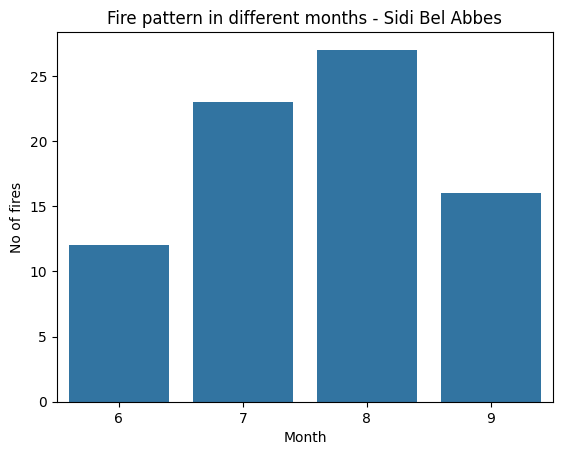

In [9]:
# checking for seasonality pattern 

conditions = ((df['Classes'] == 'fire') & (df['is_sidi_bel_region'] == 1))

df_fire_pattern = df[conditions] .groupby('month').agg({'Classes':'count'}).reset_index()

sns.barplot(x = 'month', y = 'Classes', data = df_fire_pattern)
plt.xlabel('Month')
plt.ylabel('No of fires')
plt.title('Fire pattern in different months - Sidi Bel Abbes')
plt.show()

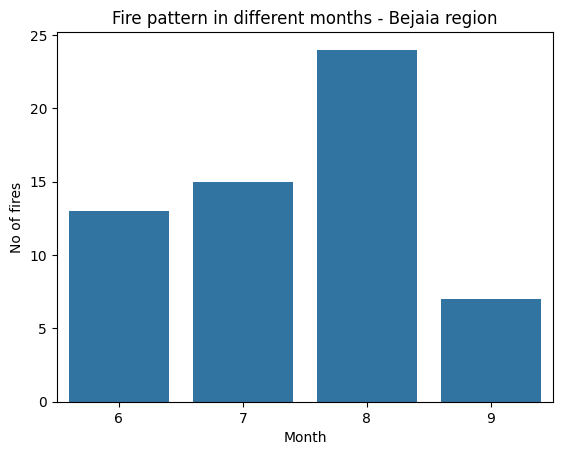

In [10]:
# checking for seasonality pattern 

conditions = ((df['Classes'] == 'fire') & (df['is_sidi_bel_region'] == 0))

df_fire_pattern = df[conditions] .groupby('month').agg({'Classes':'count'}).reset_index()

sns.barplot(x = 'month', y = 'Classes', data = df_fire_pattern)
plt.xlabel('Month')
plt.ylabel('No of fires')
plt.title('Fire pattern in different months - Bejaia region')
plt.show()

Insight - Irrespective of region - August month has maximum no of fires

In [11]:
# creating is_august Month as a feature and removing other date time

df['is_august'] = np.select([df['month'] == 8],[1],0)
df.drop(['day','month','year'], axis=1 , inplace = True)

# columns list 
df.columns

Index(['Unnamed: 0', 'Temperature', 'RH', 'Ws', 'Rain', 'FFMC', 'DMC', 'DC',
       'ISI', 'BUI', 'FWI', 'Classes', 'is_sidi_bel_region', 'is_august'],
      dtype='object')

In [12]:
# separating the dataset into two parts: one for the features and the other for the target variable
# removing Classes because weather param -> Fire Index -> Fire or no Fire

x = df.drop(['FWI','Classes','Unnamed: 0'], axis=1)
y = df['FWI']

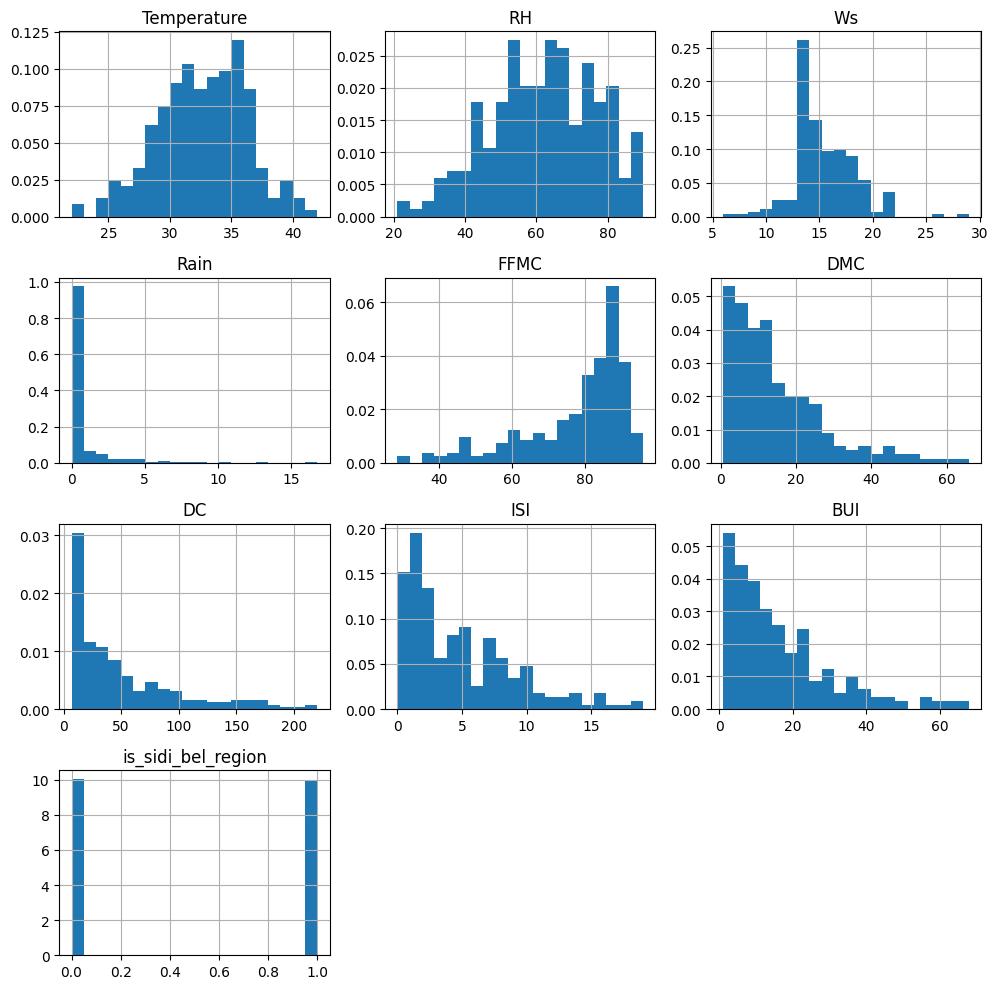

In [13]:
# checking the distribution of the all variables (Since all of them are numeric now)

non_time_series_columns = ['Temperature', 'RH', 'Ws', 'Rain', 'FFMC',
       'DMC', 'DC', 'ISI', 'BUI','is_sidi_bel_region']

x[non_time_series_columns].hist(bins = 20,figsize=(10,10),density=True)
plt.tight_layout()
plt.show()

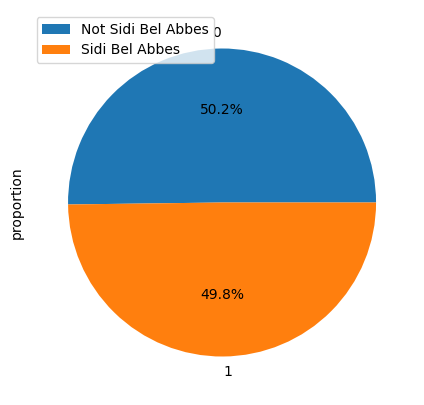

In [14]:

plt.figure(figsize=(40,20))

# separate pie for region 

percentages = x['is_sidi_bel_region'].value_counts(normalize=True) * 100
labels = ['Not Sidi Bel Abbes', 'Sidi Bel Abbes']
percentages.plot.pie(autopct='%1.1f%%' , figsize=(5,5))
plt.legend(labels = labels , loc = 'upper left') 
plt.show()

In [15]:
x.columns

Index(['Temperature', 'RH', 'Ws', 'Rain', 'FFMC', 'DMC', 'DC', 'ISI', 'BUI',
       'is_sidi_bel_region', 'is_august'],
      dtype='object')

In [16]:
# train test split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

<Axes: >

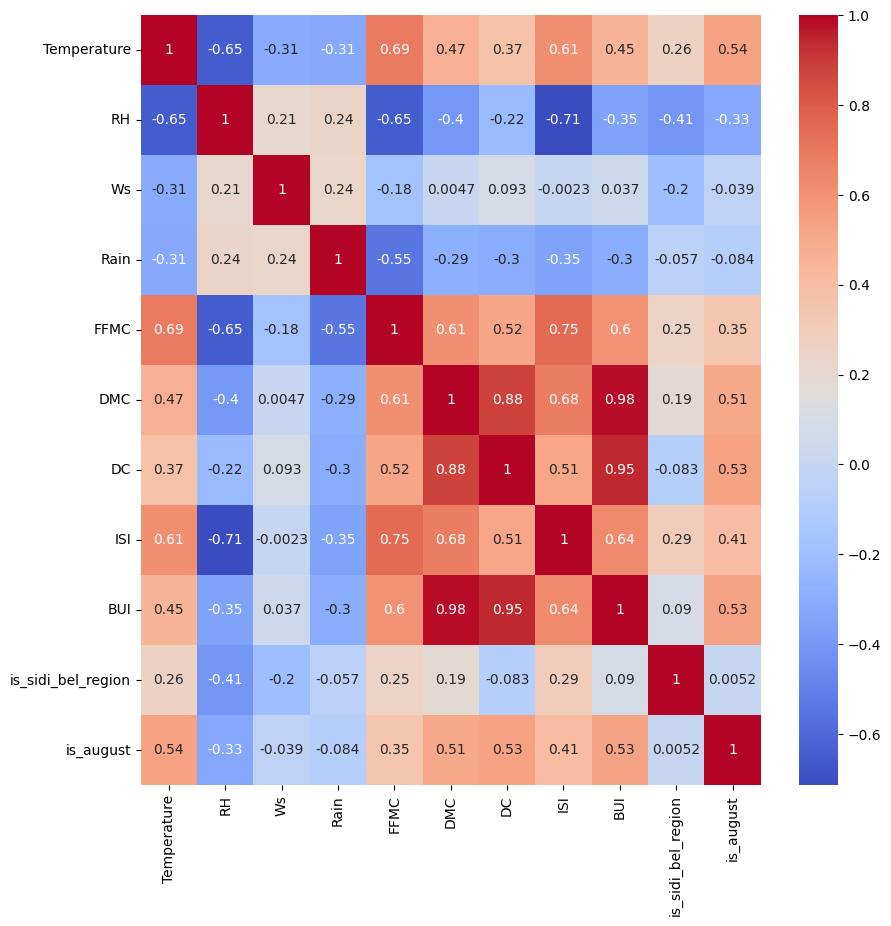

In [17]:
# check for correlation between the variables 

df_1 = x_train.loc[:,['Temperature', 'RH', 'Ws', 'Rain', 'FFMC',
       'DMC', 'DC', 'ISI', 'BUI', 'is_sidi_bel_region','is_august']]

df_1.corr()

# using the visual representation of the correlation matrix

plt.figure(figsize=(10,10))
sns.heatmap(df_1.corr(), annot=True, cmap='coolwarm')

In [18]:
# function to remove correlated features 

def correlated_features(df, threshold):
    col_corr = set() # Set of all the names of correlated columns
    corr_matrix = df.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
    return col_corr

In [19]:
# removing correlated features (Features above 0.8 correlation will be removed)

correlated_feature_list = correlated_features(df_1, 0.8)

print("The correlated features are: ", correlated_feature_list)

# dropping the correlated features
x_train.drop(correlated_feature_list, axis=1, inplace=True)

x_test.drop(correlated_feature_list, axis=1, inplace=True)



The correlated features are:  {'DC', 'BUI'}


In [20]:
# checking the final predictors 
x_train.columns

Index(['Temperature', 'RH', 'Ws', 'Rain', 'FFMC', 'DMC', 'ISI',
       'is_sidi_bel_region', 'is_august'],
      dtype='object')

In [21]:
# checking the dimensions of train test and predictor 

print("The shape of the train dataset is: ", x_train.shape)
print("The shape of the test dataset is: ", x_test.shape)
print("The shape of the train target variable is: ", y_train.shape)
print("The shape of the test target variable is: ", y_test.shape)

The shape of the train dataset is:  (194, 9)
The shape of the test dataset is:  (49, 9)
The shape of the train target variable is:  (194,)
The shape of the test target variable is:  (49,)


In [22]:
# Feature scaling 

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

C:\Users\abhin\AppData\Local\Temp\ipykernel_5844\1091556800.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(x_train.columns, rotation=90)


Text(0.5, 1.0, 'After Scaling')

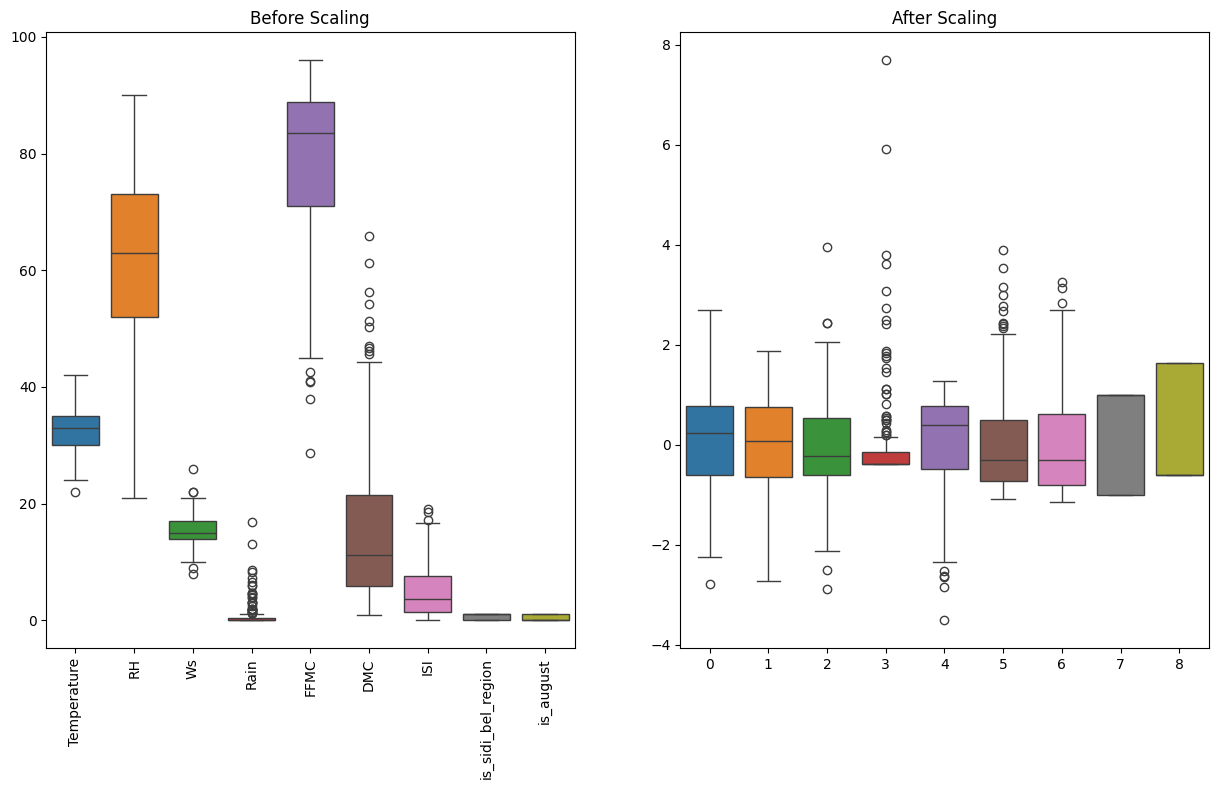

In [23]:
# checking the impact of scaling 

fig,ax = plt.subplots(1,2,figsize=(15,8))

sns.boxplot(data = x_train, ax=ax[0])
ax[0].set_title('Before Scaling')
ax[0].set_xticklabels(x_train.columns, rotation=90)

sns.boxplot(data = x_train_scaled, ax=ax[1])
ax[1].set_title('After Scaling')

## Modelling

In [24]:
# Linear regression model

model = LinearRegression()
model.fit(x_train_scaled, y_train)



# Model performance 

mse = cross_val_score(model,x_train_scaled,y_train,scoring='neg_mean_squared_error',cv=5)
mean_mse = np.mean(mse)

print(f"the mean squared error is {mean_mse}")

the mean squared error is -2.4328330263600138


In [25]:
# Trying ridge regression

ridge_reg = Ridge()
parameters = {'alpha' : [1e-15 , 1e-10 , 1e-8 , 1e-3 , 1e-2 , 1 , 5 , 10 , 20 , 30 , 35 , 40 , 45 , 50 , 55 , 100]}
ridge_regressor = GridSearchCV(ridge_reg,parameters,scoring = 'neg_mean_squared_error',cv = 5)
ridge_regressor.fit(x_train_scaled,y_train)


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [1e-15, 1e-10, 1e-08, 0.001, 0.01, 1, 5, 10,
                                   20, 30, 35, 40, 45, 50, 55, 100]},
             scoring='neg_mean_squared_error')

In [26]:
# Ridge model param 

print(ridge_regressor.best_params_)
print(ridge_regressor.best_score_)

{'alpha': 5}
-2.4083299456878375


We see marginal improvement - Not much change 

In [27]:
# Trying lasso regression 

lasso_regression = Lasso()
parameters = {'alpha' : [1e-15 , 1e-10 , 1e-8 , 1e-3 , 1e-2 , 1 , 5 , 10 , 20 , 30 , 35 , 40 , 45 , 50 , 55 , 100]}
lasso_regressor = GridSearchCV(lasso_regression,parameters,scoring = 'neg_mean_squared_error',cv=5)

lasso_regressor.fit(x_train_scaled , y_train)



g:\My Drive\1 - Projects\Algerian Forest Fire\venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.980e+01, tolerance: 9.104e-01
  model = cd_fast.enet_coordinate_descent(
g:\My Drive\1 - Projects\Algerian Forest Fire\venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.331e+01, tolerance: 9.824e-01
  model = cd_fast.enet_coordinate_descent(
g:\My Drive\1 - Projects\Algerian Forest Fire\venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the fe

GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [1e-15, 1e-10, 1e-08, 0.001, 0.01, 1, 5, 10,
                                   20, 30, 35, 40, 45, 50, 55, 100]},
             scoring='neg_mean_squared_error')

In [28]:
# lasso regression model param 

print(lasso_regressor.best_params_)
print(lasso_regressor.best_score_)

{'alpha': 0.01}
-2.405173756273432


In [29]:
# checking model performance on the test data 

# Linear regression 
pred_y_regression = model.predict(x_test_scaled)

# Ridge regression 
pred_y_ridge = ridge_regressor.predict (x_test_scaled)

# Lasso regression 
pred_y_lasso = lasso_regressor.predict (x_test_scaled)


r2_linear_regression = r2_score(y_test,pred_y_regression)
r2_ridge_regression = r2_score(y_test,pred_y_ridge)
r2_lasso_regression = r2_score(y_test,pred_y_lasso)

print(f"The r2 for linear regression is {r2_linear_regression} , for ridge regression is {r2_ridge_regression} , for lasso regression is {r2_lasso_regression}")

mse_linear_regression = mean_squared_error(y_test,pred_y_regression)
mse_ridge_regression = mean_squared_error(y_test,pred_y_ridge)
mse_lasso_regression = mean_squared_error(y_test,pred_y_lasso)


print(f"The mse for linear regression is {mse_linear_regression} , for ridge regression is {mse_ridge_regression} , for lasso regression is {mse_lasso_regression}")



The r2 for linear regression is 0.9773693052057097 , for ridge regression is 0.9727637780953895 , for lasso regression is 0.9776004835722781
The mse for linear regression is 0.6859006364605575 , for ridge regression is 0.8254868933085793 , for lasso regression is 0.6788939850869896


In [34]:
# save the model to a pickle file

joblib.dump(model, 'linear_regression_model.pkl')

# save the scaler 

joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']